In [1]:
# Import modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm


# silence warnings
import warnings
warnings.filterwarnings('ignore')

# Clean and filter dataset

In [2]:

# Link might need to be updated based on GitHub
df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group036_fa20/master/Datasets/games-features.csv?token=AFASGDG236VMGHN44GU6Z4K72JSFU')

df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')
df = df.loc[df['ReleaseDate'].notnull()]
df = df.loc[df['GenreIsNonGame'] == False]
# CONSIDER DROPPING GAMES THAT HAVEN'T BEEN OWNED
df = df.loc[df['SteamSpyOwners'] > 0]
df = df.drop(columns=['QueryID', 'ResponseID', 'QueryName', 'PackageCount',
                      'AchievementHighlightedCount', 'AchievementCount', 'ControllerSupport', 'PCReqsHaveMin',
                      'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
                      'MacReqsHaveRec', 'SupportEmail', 'SupportURL', 'ExtUserAcctNotice',
                      'HeaderImage', 'LegalNotice', 'Website', 'PCMinReqsText',
                      'PCRecReqsText', 'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText',
                      'MacRecReqsText'])
# log of SteamSpyOwners
df['log_owners'] = np.log(df['SteamSpyOwners'])

df['ReleaseYear'] = df['ReleaseDate'].dt.year
df.head()

,ResponseName,ReleaseDate,RequiredAge,DemoCount,DeveloperCount,DLCCount,Metacritic,MovieCount,RecommendationCount,PublisherCount,...,PriceFinal,AboutText,Background,ShortDescrip,DetailedDescrip,DRMNotice,Reviews,SupportedLanguages,log_owners,ReleaseYear
0,Counter-Strike,2000-11-01,0,0,1,0,88,0,68991,1,...,9.99,Play the worlds number 1 online action game. E...,http://cdn.akamai.steamstatic.com/steam/apps/1...,,Play the worlds number 1 online action game. E...,,,English French German Italian Spanish Simplifi...,16.383021,2000
1,Team Fortress Classic,1999-04-01,0,0,1,0,0,0,2439,1,...,4.99,One of the most popular online action games of...,http://cdn.akamai.steamstatic.com/steam/apps/2...,,One of the most popular online action games of...,,,English French German Italian Spanish,15.501750,1999
2,Day of Defeat,2003-05-01,0,0,1,0,79,0,2319,1,...,4.99,Enlist in an intense brand of Axis vs. Allied ...,http://cdn.akamai.steamstatic.com/steam/apps/3...,,Enlist in an intense brand of Axis vs. Allied ...,,,English French German Italian Spanish,15.846432,2003
3,Deathmatch Classic,2001-06-01,0,0,1,0,0,0,888,1,...,4.99,Enjoy fast-paced multiplayer gaming with Death...,http://cdn.akamai.steamstatic.com/steam/apps/4...,,Enjoy fast-paced multiplayer gaming with Death...,,,English French German Italian Spanish,15.830276,2001
4,Half-Life: Opposing Force,1999-11-01,0,0,1,0,0,0,2934,1,...,4.99,Return to the Black Mesa Research Facility as ...,http://cdn.akamai.steamstatic.com/steam/apps/5...,,Return to the Black Mesa Research Facility as ...,,,English French German Korean,15.501817,1999


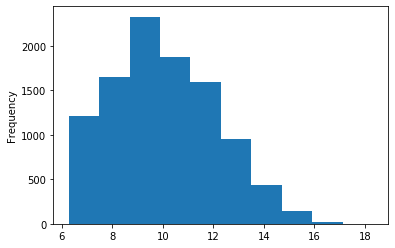

In [3]:
df['log_owners'].plot(kind = 'hist')

In [4]:
threshold = 10
df['Popular'] = df['log_owners'].apply(lambda x: True if x >= threshold else False)



In [7]:
lst = ['CategorySinglePlayer', 'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO', 
       'CategoryInAppPurchase', 'CategoryIncludeSrcSDK', 'CategoryIncludeLevelEditor', 
       'CategoryVRSupport', 'Popular']
subset = df[lst]

# Split data into train and test data by 30% 70% split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(subset.drop(columns = ['Popular']), 
                                                    np.array(subset['Popular']).reshape(-1,1), test_size = 0.3)

# Test classification on Categories

In [9]:
svm = SVC(kernel = 'linear', C = 0.025, random_state = 101)
lr = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)


In [10]:
agg_models = [lr, dtree, svm]
model_names = ['lr', 'dtree', 'svm']

In [11]:
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors = i)
    model_names.append('knn' + str(i))
    agg_models.append(knn)


In [12]:
score_lst = []
for i in range(len(agg_models)):
    model = agg_models[i]
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    score_lst.append([model.score(x_train, y_train), model.score(x_test, y_test)])

In [13]:
joined_scores = pd.DataFrame(dict(zip(model_names, score_lst))).T
joined_scores.columns = ['train_score', 'test_score']
joined_scores.head()

,train_score,test_score
lr,0.579337,0.589041
dtree,0.581434,0.588715
svm,0.574864,0.584475
knn1,0.455753,0.447162
knn2,0.444988,0.436073


# Result: Decision Tree shows best prediction of train data and Logistic Regression shows best prediction of test data

In [16]:
display(joined_scores.loc[joined_scores['train_score'].idxmax()])
display(joined_scores.loc[joined_scores['test_score'].idxmax()])

train_score    0.581434
test_score     0.588715
Name: dtree, dtype: float64

train_score    0.579337
test_score     0.589041
Name: lr, dtype: float64

# Cross Validation Scores Using Entire Dataset

In [18]:
svm = SVC(kernel = 'linear', C = 0.025, random_state = 101)
lr = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)

In [19]:
agg_models = [lr, dtree, svm]
model_names = ['lr', 'dtree', 'svm']

In [20]:
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors = i)
    model_names.append('knn' + str(i))
    agg_models.append(knn)


In [21]:
scores = {}
for i in range(len(agg_models)):
    score = cross_val_score(agg_models[i], subset.drop(columns = ['Popular']), subset['Popular'], cv =5)
    scores[model_names[i]] = score

In [22]:
scores_df = pd.DataFrame(scores).T
scores_df['mean'] = scores_df.apply(lambda x: x.mean(), axis = 1)
scores_df.columns = ['1st_set', '2nd_set', '3rd_set', '4th_set', '5th_set', 'mean']
scores_df.head()

,1st_set,2nd_set,3rd_set,4th_set,5th_set,mean
lr,0.582885,0.591198,0.546256,0.589819,0.581498,0.578331
dtree,0.596088,0.603912,0.546745,0.585414,0.576114,0.581654
svm,0.589242,0.597555,0.544787,0.583456,0.573666,0.577741
knn1,0.434719,0.458680,0.464023,0.470387,0.586882,0.482938
knn2,0.433741,0.559413,0.458639,0.473813,0.577093,0.500540


# Results of Cross Validation Scores: decision tree has the highest mean score

In [24]:
display(scores_df.loc[scores_df['mean'].idxmax()])


1st_set    0.596088
2nd_set    0.603912
3rd_set    0.546745
4th_set    0.585414
5th_set    0.576114
mean       0.581654
Name: dtree, dtype: float64